In [1]:
import numpy as np
from scipy.interpolate import griddata
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

from keras.utils import to_categorical

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15,8]

C:\Users\andre\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Instructions on using Keras

Models in Keras are defined as a sequence of layers.

We create a [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) object which holds multiple layers executed one by one, and add layers to the object until we have formed the architecture.

To create the first layer, you need to know the right number of input features. You can specify this by using the `input_dim` argument. 

The things to choose when defining the architecture are many:
 - number of layers
 - type of layers
 - size of layers
 - type of non-linearity
 - whether or not to add regularization
 
Here we will use only fully-connected (dense) layers, so the type of layer is fixed. Fully connected layers are defined using the [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) class, which takes as parameters the number of neurons (which is the **dimension of the output**).

The activation functions are used after each dense layer. You can choose the activation functions for hidden layers yourself, a common choice being the [ReLU](https://www.tensorflow.org/api_docs/python/tf/keras/activations/relu) activation. But for the last layer, the activation must reflect the range of the outputs.

Since we will work with binary classification problem, the output should be between 0 and 1, which is then easy to map to any given class. To ensure this we can use the [Sigmoid](https://www.tensorflow.org/api_docs/python/tf/keras/activations/sigmoid) activation.


After having created a model you need to **compile** it. During the compilation phase you must specify some parameters related to how the model will be optimized:
 - The `optimizer`. For the following exercise you should use [SGD](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD), initialized with some learning rate (instructions on how to choose it follow).
 - The `loss` function. For binary classification you can use the [cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy) loss.
 - A list of `metrics`: common error functions which you want keras to report at each training epoch.
 
Then you may actually train the model by calling **fit**. The fit function takes as input the training data, and some more parameters related to the training process:
 - `epochs` : the number of epochs to train for
 - `batch_size` : the size of mini-batches. A high batch-size will speed up computations but may make training unstable.
 
Other useful functions are `model.predict` which runs the model's forward pass to predict on new samples, and `model.evaluate` which is similar to `predict` but instead of giving predictions as output, it simply computes some metrics.

In [2]:
def generate_2d_cls_data(n, sigma_noise):
    n_cls = n // 2
    
    theta = np.random.randn(n_cls) * 2 * np.pi
    cls1 = np.stack([np.cos(theta) * 2, np.sin(theta) * 2], axis=1)
    cls2 = np.random.randn(n_cls, 2) * 0.5

    cls1 += np.random.randn(cls1.shape[0], 2) * sigma_noise * 3
    cls2 += np.random.randn(cls2.shape[0], 2) * sigma_noise
    
    X = np.concatenate([cls1, cls2], axis=0)
    y = np.concatenate([np.zeros(n_cls), np.ones(n_cls)], axis=0)
    
    return X, y

In [3]:
def separatingFLR(data, labels, predictions, model):
    fig, ax = plt.subplots()
    
    num_grid_points = 100
    xi = np.linspace(data[:, 0].min(), data[:, 0].max(), num_grid_points)
    yi = np.linspace(data[:, 1].min(), data[:, 1].max(), num_grid_points)
    gdata = np.stack([xi, yi], 1)
    X, Y = np.meshgrid(xi,yi)
    pred_grid = model.predict(
        np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
    ).reshape(num_grid_points, num_grid_points)
    
    ax.contour(xi, yi, pred_grid, 15, linewidths=2, colors='k', levels=[0.5])
    # plot data points.
    ax.scatter(data[:,0], data[:,1], c=labels.ravel(), marker='o', s=100, zorder=10, alpha=0.8)
    ax.set_xlim(data[:,0].min(), data[:,0].max())
    ax.set_ylim(data[:,1].min(), data[:,1].max())
    return fig, ax

In [4]:
def calc_err(predicted, observed):
    predicted = predicted.ravel()
    observed = observed.ravel()
    threshold_preds = predicted.copy()
    threshold_preds[predicted < 0.5] = 0
    threshold_preds[predicted >= 0.5] = 1
    return np.mean(threshold_preds != observed)

### Synthetic Example

#### Generating the train and test sets

Note that with neural nets, the labels for binary classification should be 0 and +1.

In [5]:
# put your code here
Xtr, Ytr = generate_2d_cls_data(500, 0.2)
Xte, Yte = generate_2d_cls_data(500, 0.2)

In [6]:
# Build your first model by creating a Sequential object and then adding 2 Dense layers:
model = Sequential()
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # This is the last layer, it should have 1 neuron and the sigmoid activation
model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=600,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/600


40/40 [==============================] - 2s 16ms/step - loss: 0.6956 - accuracy: 0.4750 - val_loss: 0.8503 - val_accuracy: 0.0700
Epoch 2/600
40/40 [==============================] - 0s 6ms/step - loss: 0.6103 - accuracy: 0.5375 - val_loss: 0.9073 - val_accuracy: 0.0000e+00
Epoch 3/600
40/40 [==============================] - 0s 6ms/step - loss: 0.5813 - accuracy: 0.5825 - val_loss: 0.9010 - val_accuracy: 0.0000e+00
Epoch 4/600
40/40 [==============================] - 0s 6ms/step - loss: 0.5618 - accuracy: 0.5850 - val_loss: 0.8720 - val_accuracy: 0.0000e+00
Epoch 5/600
40/40 [==============================] - 0s 6ms/step - loss: 0.5456 - accuracy: 0.5875 - val_loss: 0.8349 - val_accuracy: 0.2700
Epoch 6/600
40/40 [==============================] - 0s 6ms/step - loss: 0.5314 - accuracy: 0.6500 - val_loss: 0.8134 - val_accuracy: 0.3700
Epoch 7/600
40/40 [==============================] - 0s 6ms/step - loss: 0.5189 - accuracy: 0.6775 - val_loss: 0.7880 - val_accuracy: 0.4500
Epoch 8/600


#### Plot the results from the model

In [5]:
# With this function you can plot the history of the model training produced by the fit function
def plot_history(history):
    fig, ax = plt.subplots()
    # Plot training & validation accuracy values
    ax.plot(history.history['accuracy'], label='Train')
    ax.plot(history.history['val_accuracy'], label='Val')
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(loc='best')
    return fig, ax

 14/313 [>.............................] - ETA: 1s 

313/313 [==============================] - 1s 3ms/step


Text(0.5, 1.0, 'Accuracy evolution over epochs')

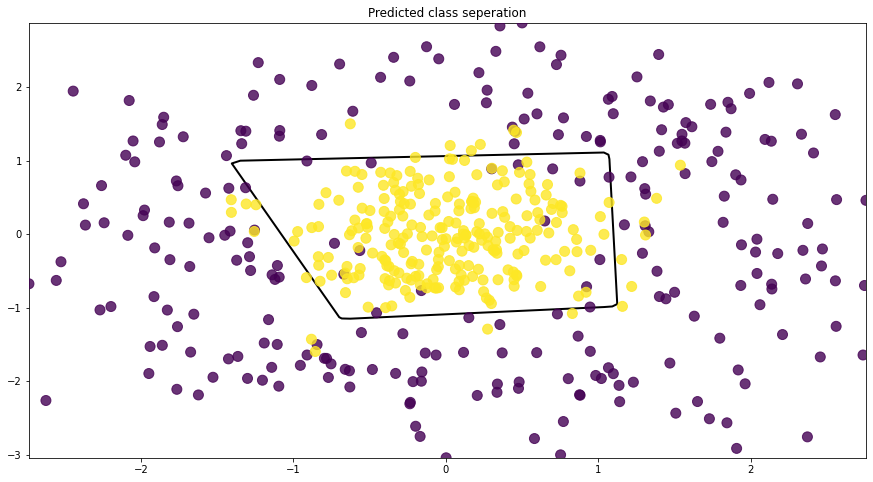

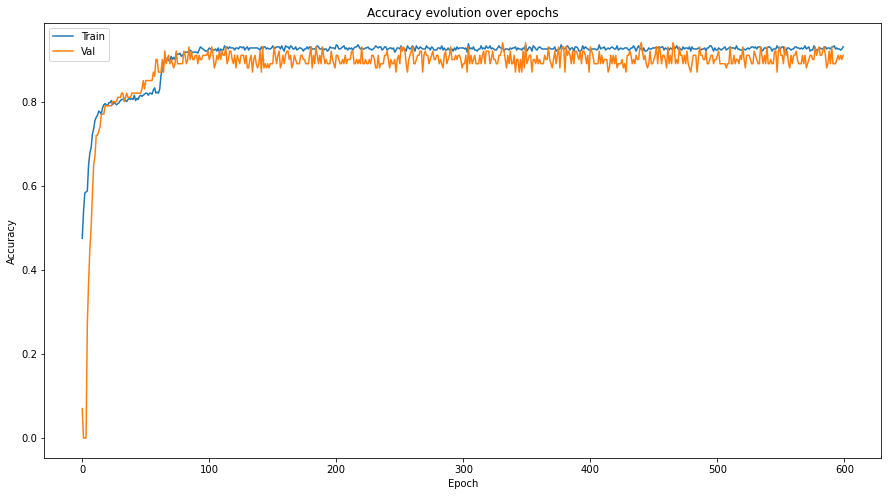

In [8]:
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs")

## Exploring Different Architectures

Using a simple binary classification dataset you will build a keras model with Dense layers, and the RELU activation function.

You will explore different architectures to try and see when the NN overfits or underfits the data.

In particular, you should try the following:
 1. A NN with a single hidden layer with many (e.g. 100) neurons
 2. A NN with many (e.g. 3, 4, 5) hidden layers with a few neurons (e.g. 10 to 30).
 
Train the neural network using the SGD algorithm with a learning rate of 0.05 (you may explore different values) for 500 epochs (or less if time doesn't permit).

For each setting you try, plot the training and validation errors as a function of the epochs, and plot the separating function (use the `separatingFLR` function).

For each setting comment on whether the NN is overfitting or not. Further comment on which model you believe is better, and why (e.g. computational or accuracy considerations).

We provide some skeleton code to train and evaluate a model, you'll have to fill it in, and do the same thing multiple times for different models.

#### 1) NN with single layer with 100 neurons

In [9]:
Xtr, Ytr = generate_2d_cls_data(1000, 0.2)
Xte, Yte = generate_2d_cls_data(1000, 0.2)

In [10]:
# Build your first model by creating a Sequential object and then adding 3 Dense layers:
model = Sequential()

# Add layers
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)

# Fit model
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=200,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/200


80/80 [==============================] - 2s 13ms/step - loss: 0.5993 - accuracy: 0.6062 - val_loss: 0.8912 - val_accuracy: 0.0000e+00
Epoch 2/200
80/80 [==============================] - 1s 7ms/step - loss: 0.5165 - accuracy: 0.7063 - val_loss: 0.8273 - val_accuracy: 0.3600
Epoch 3/200
80/80 [==============================] - 1s 7ms/step - loss: 0.4428 - accuracy: 0.8138 - val_loss: 0.7139 - val_accuracy: 0.6150
Epoch 4/200
80/80 [==============================] - 1s 8ms/step - loss: 0.3751 - accuracy: 0.8537 - val_loss: 0.6690 - val_accuracy: 0.6700
Epoch 5/200
80/80 [==============================] - 1s 8ms/step - loss: 0.3183 - accuracy: 0.8875 - val_loss: 0.5625 - val_accuracy: 0.7500
Epoch 6/200
80/80 [==============================] - 1s 9ms/step - loss: 0.2719 - accuracy: 0.9025 - val_loss: 0.4352 - val_accuracy: 0.8350
Epoch 7/200
80/80 [==============================] - 1s 7ms/step - loss: 0.2380 - accuracy: 0.9325 - val_loss: 0.3536 - val_accuracy: 0.8900
Epoch 8/200
80/80 [=

 14/313 [>.............................] - ETA: 1s 

313/313 [==============================] - 1s 4ms/step


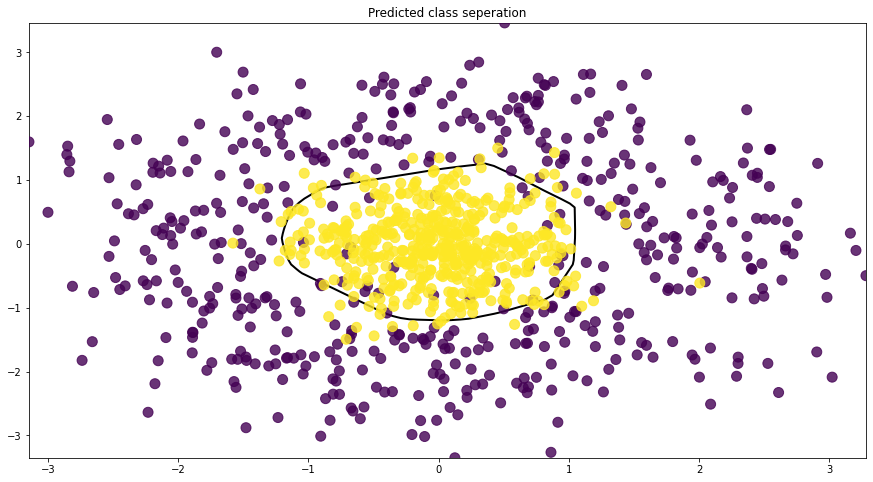

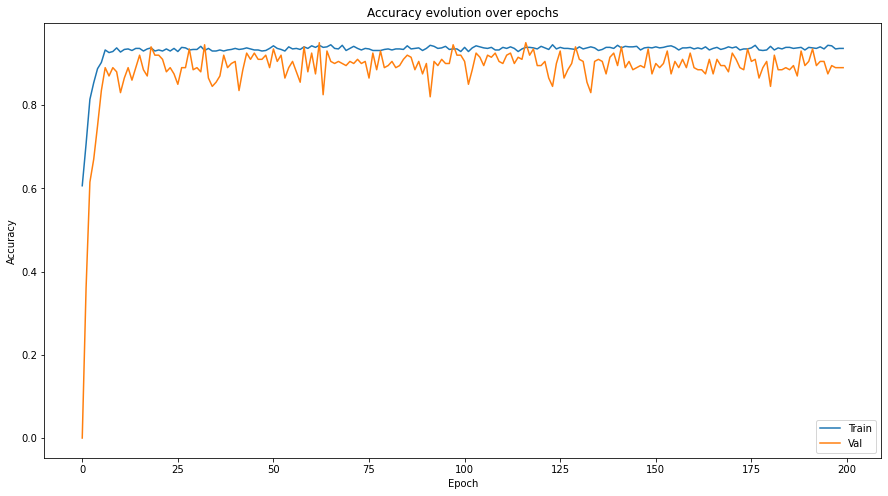

In [11]:
# Plot separating function
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

#### 2) NN with 4 hidden layer with  40 neurons

In [12]:
Xtr, Ytr = generate_2d_cls_data(1000, 0.2)
Xte, Yte = generate_2d_cls_data(1000, 0.2)

In [13]:
# Repeat the previous code but with 4 hidden layers with 40 neurons (in each layer) 
model = Sequential()

# Add layers
model.add(Dense(4, input_dim=2, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.05), # Algorithm used for optimization
    loss='binary_crossentropy',                         # The loss function
    metrics=['accuracy'],                               # Metrics to evaluate the goodness of predictions
)

# Fit model
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=200,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xte)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yte)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

Epoch 1/200
80/80 [==============================] - 2s 10ms/step - loss: 0.6183 - accuracy: 0.6200 - val_loss: 0.9230 - val_accuracy: 0.0000e+00
Epoch 2/200
80/80 [==============================] - 0s 6ms/step - loss: 0.4521 - accuracy: 0.7613 - val_loss: 0.7204 - val_accuracy: 0.7050
Epoch 3/200
80/80 [==============================] - 0s 6ms/step - loss: 0.3068 - accuracy: 0.8975 - val_loss: 0.4575 - val_accuracy: 0.8850
Epoch 4/200
80/80 [==============================] - 0s 6ms/step - loss: 0.2424 - accuracy: 0.9175 - val_loss: 0.4974 - val_accuracy: 0.8400
Epoch 5/200
80/80 [==============================] - 0s 6ms/step - loss: 0.2302 - accuracy: 0.9075 - val_loss: 0.2922 - val_accuracy: 0.9150
Epoch 6/200
80/80 [==============================] - 0s 6ms/step - loss: 0.2214 - accuracy: 0.9100 - val_loss: 0.3313 - val_accuracy: 0.9000
Epoch 7/200
80/80 [==============================] - 0s 6ms/step - loss: 0.2173 - accuracy: 0.9112 - val_loss: 0.2489 - val_accuracy: 0.9100
Epoch 8/

313/313 [==============================] - 1s 4ms/step


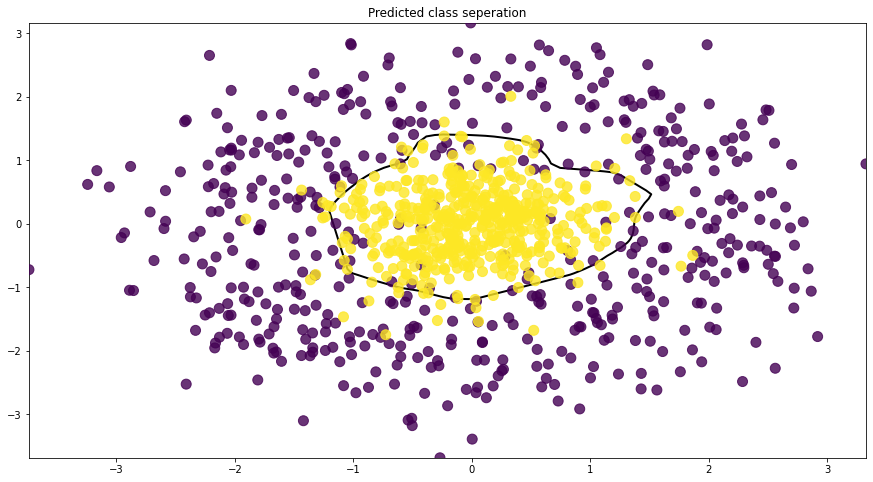

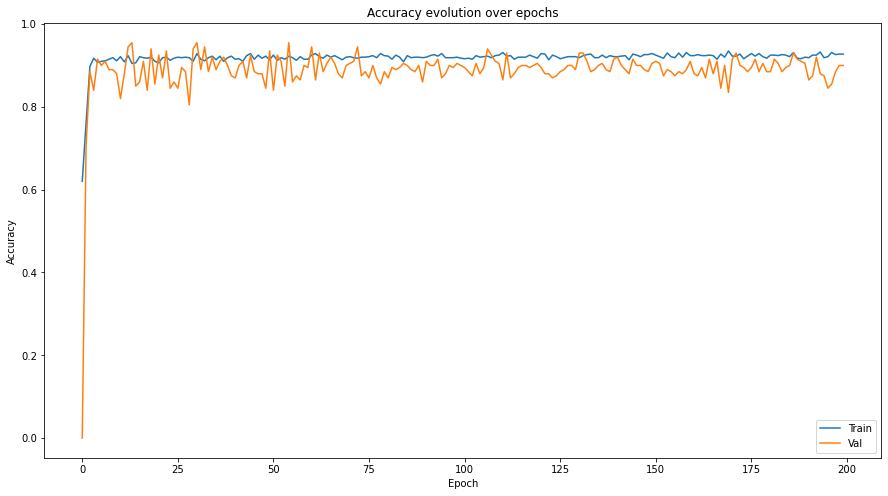

In [14]:
# Plot separating function
fig, ax = separatingFLR(Xtr, Ytr, train_preds, model)
ax.set_title("Predicted class seperation");
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs");

For sure, the first model is simpler than the second one because it has a lesser number of weights to learn; it's provided with 500 weights while the second one has 5000 ones. This means that the first model is less prone to overfitting than the second one. In fact we can notice that the separating curve derived from the second neural network follows the data noise more than the first one. Furthermore, the second model is more complex because it takes much more time to train.

Regarding the test errors, the second model has a smaller error than the first one, probably because it's overfitting so much that it overfits the noise as well.

Since the problem is not so complex, the first model is better than the second one because it's simpler, it's not overfitting and it takes less time.

NB: the number of epochs has been reduced to 200 for time reasons (and the trend of the accuracy was kind of stable from that point on)

## Train a Neural Network on MNIST!

We can finally switch to a real dataset now.

First we will load the MNIST dataset and plot it to see how it really looks like.

Then we will use the notions learned in the first part to train a model which can distinguish two digits in the MNIST data.

As a bonus, some of you may want to look into multi-class classification and train a model on the whole MNIST dataset!

## Load Data

In [15]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print("Training set shapes: ", x_train.shape, y_train.shape)
print("Test set shapes: ", x_test.shape, y_test.shape)

Training set shapes:  (60000, 28, 28) (60000,)
Test set shapes:  (10000, 28, 28) (10000,)


#### Bring the data into shape

1. Choose the digits we want to classify (variables `num_1` and `num_2`)
2. Then we restrict training and test sets to only use those numbers
3. We reshape the images from 28*28 to a single 784-dimensional vector
4. Finally we modify the labels to their appropriate range (0 and +1)

In [16]:
num_1 = 1
num_2 = 7

# Here we take only two digits from MNIST. 
# We will reduce the problem to binary classification.
Xtr = x_train[(y_train == num_1) | (y_train == num_2)]
Ytr = y_train[(y_train == num_1) | (y_train == num_2)]
Xts = x_test[(y_test == num_1) | (y_test == num_2)]
Yts = y_test[(y_test == num_1) | (y_test == num_2)]

# Reshape the data correctly
Xtr = Xtr.reshape(-1, 28*28)
Xts = Xts.reshape(-1, 28*28)
Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

We can visualize the images...

Text(0.5, 1.0, '0')

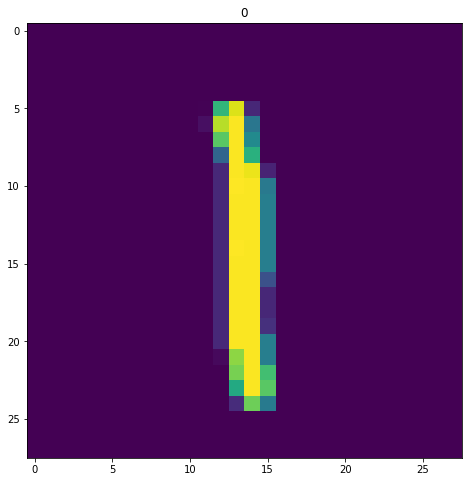

In [17]:
fig, ax = plt.subplots()
ax.imshow(Xtr[3].reshape(28, 28))
ax.set_title(Ytr[3])

#### Define The Keras Model

In [18]:
model = Sequential()
# Add hidden layers
model.add(Dense(5, input_dim=784, activation='relu'))
model.add(Dense(5, activation='relu'))
# This is the last layer, it should have 1 neuron and the sigmoid activation
model.add(Dense(1, activation='sigmoid'))  

#### Compile The Keras Model

Here we will use the Adam optimizer instead. It tends to work better than SGD with high dimensional data (such as our MNIST images).

In [19]:
model.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics=['accuracy'],)

#### Fit the model

In [20]:
# fit the keras model on the dataset
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=25,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

Epoch 1/25


1041/1041 [==============================] - 7s 5ms/step - loss: 0.2572 - accuracy: 0.9435 - val_loss: 0.0381 - val_accuracy: 0.9789
Epoch 2/25
1041/1041 [==============================] - 5s 5ms/step - loss: 0.0349 - accuracy: 0.9878 - val_loss: 0.0202 - val_accuracy: 0.9904
Epoch 3/25
1041/1041 [==============================] - 5s 5ms/step - loss: 0.0376 - accuracy: 0.9880 - val_loss: 0.0207 - val_accuracy: 0.9912
Epoch 4/25
1041/1041 [==============================] - 5s 5ms/step - loss: 0.0204 - accuracy: 0.9931 - val_loss: 0.0225 - val_accuracy: 0.9889
Epoch 5/25
1041/1041 [==============================] - 5s 5ms/step - loss: 0.0230 - accuracy: 0.9932 - val_loss: 0.0782 - val_accuracy: 0.9854
Epoch 6/25
1041/1041 [==============================] - 5s 5ms/step - loss: 0.0157 - accuracy: 0.9968 - val_loss: 0.0258 - val_accuracy: 0.9950
Epoch 7/25
1041/1041 [==============================] - 5s 5ms/step - loss: 0.0205 - accuracy: 0.9938 - val_loss: 0.0326 - val_accuracy: 0.9954
Epo

In [21]:
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

68/68 [==============================] - 0s 4ms/step
Training error: 0.26%, Test error: 0.46%


In [22]:
# evaluate the keras model. Is this consistent with the error you computed above?
_, accuracy = model.evaluate(Xts, Yts)
print('Test accuracy: %.2f%%' % (accuracy*100))

68/68 [==============================] - 0s 4ms/step - loss: 0.0245 - accuracy: 0.9954
Test accuracy: 99.54%


It is consistent with the error computed above because they sum up to 100%

Text(0.5, 1.0, 'Accuracy evolution over epochs')

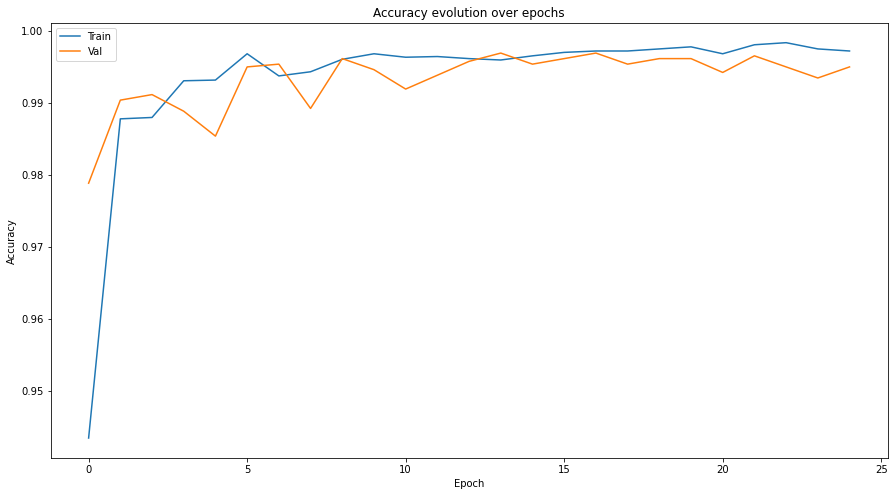

In [23]:
# Plot training history
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs")

### (Optional) Multi-class Classification

In [71]:
(Xtr, Ytr), (Xts, Yts) = keras.datasets.mnist.load_data()
print("Training set shapes: ", Xtr.shape, Ytr.shape)
print("Test set shapes: ", Xts.shape, Yts.shape)

Xtr = Xtr.reshape(-1, 28*28)
Xts = Xts.reshape(-1, 28*28)

Ytr = to_categorical(Ytr, num_classes=10)
Yts = to_categorical(Yts, num_classes=10)

Training set shapes:  (60000, 28, 28) (60000,)
Test set shapes:  (10000, 28, 28) (10000,)


In [72]:
model = Sequential()
# Add hidden layers
model.add(Dense(20, input_dim=784, activation='relu'))
model.add(Dense(10, activation='relu'))
# This is the last layer, it should have 1 neuron and the sigmoid activation
model.add(Dense(10, activation='softmax'))  

model.compile(
    loss='categorical_crossentropy', 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics=['accuracy'],)

# fit the keras model on the dataset
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=25,                     # Number of training epochs
    batch_size=10,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

Epoch 1/25
4800/4800 [==============================] - 9s 2ms/step - loss: 2.1314 - accuracy: 0.2823 - val_loss: 1.7778 - val_accuracy: 0.3855
Epoch 2/25
4800/4800 [==============================] - 8s 2ms/step - loss: 1.5725 - accuracy: 0.4018 - val_loss: 1.3672 - val_accuracy: 0.4908
Epoch 3/25
4800/4800 [==============================] - 7s 1ms/step - loss: 1.1856 - accuracy: 0.5532 - val_loss: 0.9316 - val_accuracy: 0.6610
Epoch 4/25
4800/4800 [==============================] - 7s 1ms/step - loss: 0.8167 - accuracy: 0.7176 - val_loss: 0.7072 - val_accuracy: 0.7690
Epoch 5/25
4800/4800 [==============================] - 7s 1ms/step - loss: 0.6025 - accuracy: 0.8324 - val_loss: 0.5004 - val_accuracy: 0.8718
Epoch 6/25
4800/4800 [==============================] - 7s 1ms/step - loss: 0.4962 - accuracy: 0.8674 - val_loss: 0.4843 - val_accuracy: 0.8659
Epoch 7/25
4800/4800 [==============================] - 7s 1ms/step - loss: 0.4435 - accuracy: 0.8827 - val_loss: 0.4243 - val_accuracy:

In [75]:
# function to calculate the error of multiclass predictions
def calc_error_multicls(predicted, observed):
    # Convert predicted probabilities to binary predictions
    predicted_binary = np.round(predicted).astype(int)
    # Count the number of wrong predictions
    wrongs = np.any(predicted_binary != observed, axis=1)
    # Calculate the error rate
    return np.sum(wrongs)/len(predicted)

In [76]:
# Predict and calculate errors
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_error_multicls(train_preds, Ytr)
test_err = calc_error_multicls(test_preds, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

   1/1875 [..............................] - ETA: 46s

313/313 [==============================] - 0s 1ms/step
Training error: 8.15%, Test error: 8.77%


In [77]:
# evaluate the keras model. Is this consistent with the error you computed above?
_, accuracy = model.evaluate(Xtr, Ytr)
print('Test accuracy: %.2f%%' % (accuracy*100))

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2464 - accuracy: 0.9336
Test accuracy: 93.36%


Text(0.5, 1.0, 'Accuracy evolution over epochs')

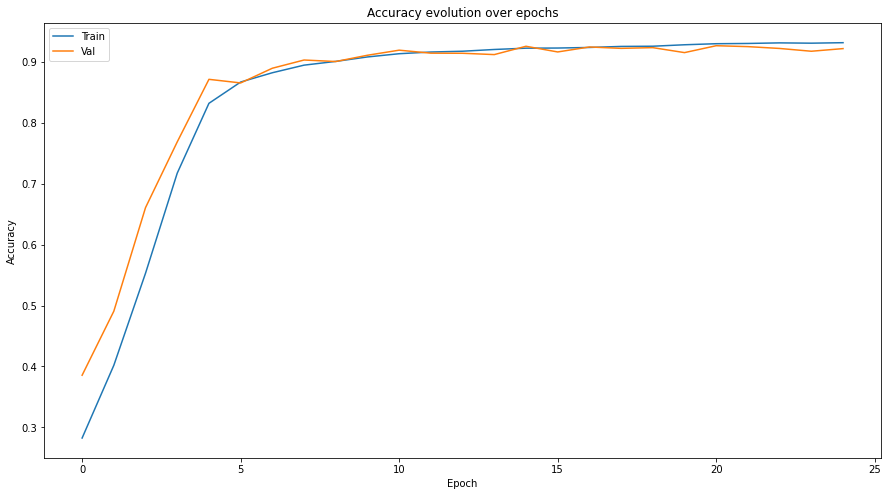

In [78]:
# Plot training history
fig, ax = plot_history(history)
ax.set_title("Accuracy evolution over epochs")

## Neural Network and Convolutional Neural Network
Implement and compare a Dense neural network and a Convolutional neural network with the following architectures:

1) Neural Network architecture: 3 layers (input, output included) with 18, 8, 1 neurons.

2) Convolutional Neural Network: 2 convolutional layers with:
    - 32 filters 
    - kernel size (3, 3) 
    - stride: first layer= 3, second layer 2  

For both networks use SGD optimizer with learning rate 0.001, batch size of 128 and 50 epochs. Note that the number of parameters of the CNN is about 10k while the number of parameters of the dense neural network is about 12k.

Convolutional layers are implemented with the class [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

In [40]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print("Training set shapes: ", x_train.shape, y_train.shape)
print("Test set shapes: ", x_test.shape, y_test.shape)

Training set shapes:  (60000, 28, 28) (60000,)
Test set shapes:  (10000, 28, 28) (10000,)


In [41]:
num_1 = 4
num_2 = 6

# Here we take only two digits from MNIST. 
# We will reduce the problem to binary classification.
Xtr = x_train[(y_train == num_1).reshape(-1) | (y_train == num_2).reshape(-1)]
Ytr = y_train[(y_train == num_1).reshape(-1) | (y_train == num_2).reshape(-1)]
Xts = x_test[(y_test == num_1).reshape(-1) | (y_test == num_2).reshape(-1)]
Yts = y_test[(y_test == num_1).reshape(-1) | (y_test == num_2).reshape(-1)]

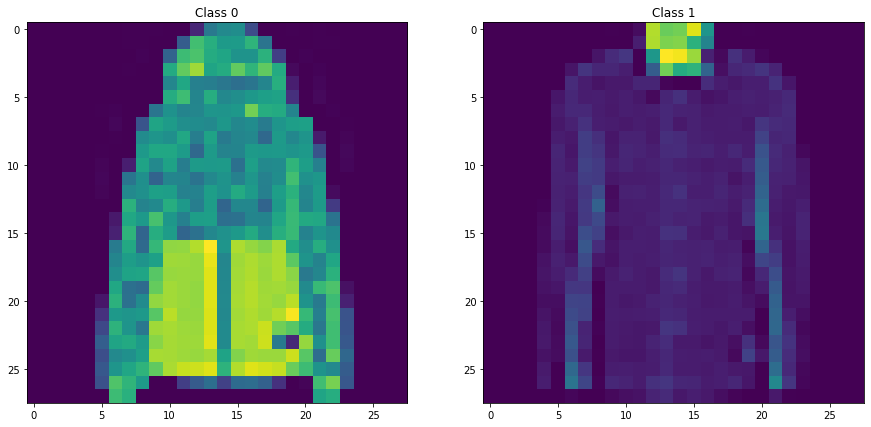

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("Class 0")
ax1.imshow(Xtr[(Ytr == num_1).reshape(-1)][1])
ax2.set_title("Class 1")
ax2.imshow(Xtr[(Ytr == num_2).reshape(-1)][2])

In [43]:
batch_size= 128
epochs = 50

**Dense network experiment** 

In [44]:
# For dense network we have to transform images in vectors
Xtr = Xtr.reshape(-1, 28*28) / 255 
Xts = Xts.reshape(-1, 28*28) / 255

Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

In [45]:
# Implement the dense network model
model = Sequential()
# Add hidden layers
model.add(Dense(18, input_dim=784, activation='relu'))
model.add(Dense(8, activation='relu'))
# This is the last layer, it should have 1 neuron and the sigmoid activation
model.add(Dense(1, activation='sigmoid'))  

In [46]:
# Compile the model
model.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.SGD(learning_rate=0.001), 
    metrics=['accuracy'],)

In [47]:
# Fit the keras model on the dataset
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=epochs,                     # Number of training epochs
    batch_size=batch_size,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

Epoch 1/50
75/75 [==============================] - 1s 5ms/step - loss: 0.7717 - accuracy: 0.4953 - val_loss: 0.7206 - val_accuracy: 0.4671
Epoch 2/50
75/75 [==============================] - 0s 3ms/step - loss: 0.6918 - accuracy: 0.5379 - val_loss: 0.6795 - val_accuracy: 0.5779
Epoch 3/50
75/75 [==============================] - 0s 2ms/step - loss: 0.6744 - accuracy: 0.5798 - val_loss: 0.6678 - val_accuracy: 0.5971
Epoch 4/50
75/75 [==============================] - 0s 2ms/step - loss: 0.6643 - accuracy: 0.5968 - val_loss: 0.6585 - val_accuracy: 0.6196
Epoch 5/50
75/75 [==============================] - 0s 2ms/step - loss: 0.6551 - accuracy: 0.6212 - val_loss: 0.6496 - val_accuracy: 0.6400
Epoch 6/50
75/75 [==============================] - 0s 2ms/step - loss: 0.6464 - accuracy: 0.6405 - val_loss: 0.6409 - val_accuracy: 0.6558
Epoch 7/50
75/75 [==============================] - 0s 2ms/step - loss: 0.6382 - accuracy: 0.6535 - val_loss: 0.6330 - val_accuracy: 0.6758
Epoch 8/50
75/75 [==

In [48]:
# Evaluate the keras model
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

63/63 [==============================] - 0s 1ms/step
Training error: 16.32%, Test error: 17.15%


In [49]:
_, accuracy = model.evaluate(Xts, Yts)
print('Test accuracy: %.2f%%' % (accuracy*100))

63/63 [==============================] - 0s 1ms/step - loss: 0.4432 - accuracy: 0.8285
Test accuracy: 82.85%


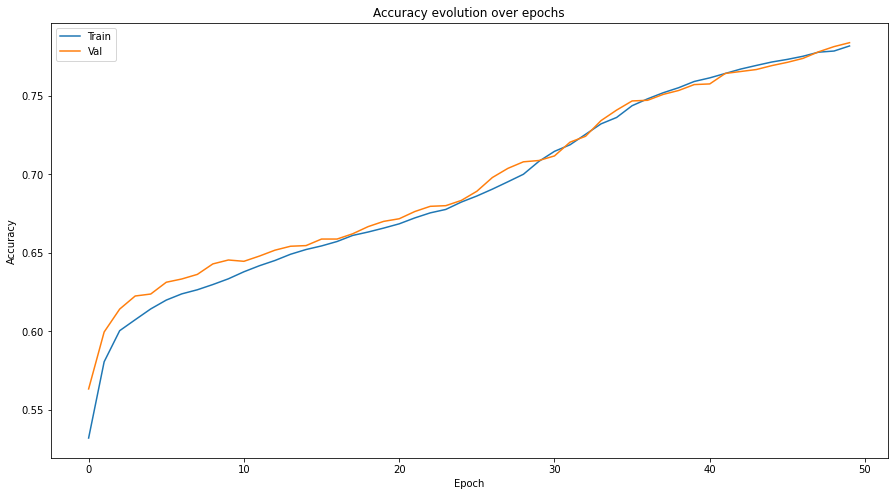

In [34]:
# Plot training history
fig, ax = plot_history(history)
_ = ax.set_title("Accuracy evolution over epochs")

**CNN experiment**: Repeat the previous experiment but using a CNN instead of the dense network

In [31]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=3, activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(filters=32, kernel_size=(3,3), strides=2, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))  

In [32]:
# Compile model
model.compile(
    loss='binary_crossentropy', 
    optimizer=keras.optimizers.SGD(learning_rate=0.001), 
    metrics=['accuracy'],)

In [33]:
# Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

Xtr = x_train[(y_train == num_1) | (y_train == num_2)]
Ytr = y_train[(y_train == num_1) | (y_train == num_2)]
Xts = x_test[(y_test == num_1) | (y_test == num_2)]
Yts = y_test[(y_test == num_1) | (y_test == num_2)]


Xtr = Xtr.reshape((-1, 28, 28, 1)) 
Xts = Xts.reshape((-1, 28, 28, 1)) 


Ytr[Ytr == num_1] = 0
Ytr[Ytr == num_2] = 1
Yts[Yts == num_1] = 0
Yts[Yts == num_2] = 1

In [34]:
# Fit the keras model on the dataset
history = model.fit(
    Xtr, Ytr,                       # Training data
    epochs=epochs,                     # Number of training epochs
    batch_size=batch_size,                  # Train using mini-batches of 10 samples each
    validation_split=0.2,           # Split the data using 80% to train and 20% for validation
)

Epoch 1/50
75/75 [==============================] - 1s 7ms/step - loss: 1.3400 - accuracy: 0.7086 - val_loss: 0.5715 - val_accuracy: 0.7479
Epoch 2/50
75/75 [==============================] - 0s 5ms/step - loss: 0.5129 - accuracy: 0.7854 - val_loss: 0.4852 - val_accuracy: 0.7879
Epoch 3/50
75/75 [==============================] - 0s 5ms/step - loss: 0.4456 - accuracy: 0.8085 - val_loss: 0.4446 - val_accuracy: 0.8075
Epoch 4/50
75/75 [==============================] - 0s 5ms/step - loss: 0.4064 - accuracy: 0.8280 - val_loss: 0.4154 - val_accuracy: 0.8171
Epoch 5/50
75/75 [==============================] - 0s 5ms/step - loss: 0.3820 - accuracy: 0.8410 - val_loss: 0.3925 - val_accuracy: 0.8288
Epoch 6/50
75/75 [==============================] - 0s 5ms/step - loss: 0.3611 - accuracy: 0.8496 - val_loss: 0.3870 - val_accuracy: 0.8279
Epoch 7/50
75/75 [==============================] - 0s 5ms/step - loss: 0.3468 - accuracy: 0.8578 - val_loss: 0.3661 - val_accuracy: 0.8433
Epoch 8/50
75/75 [==

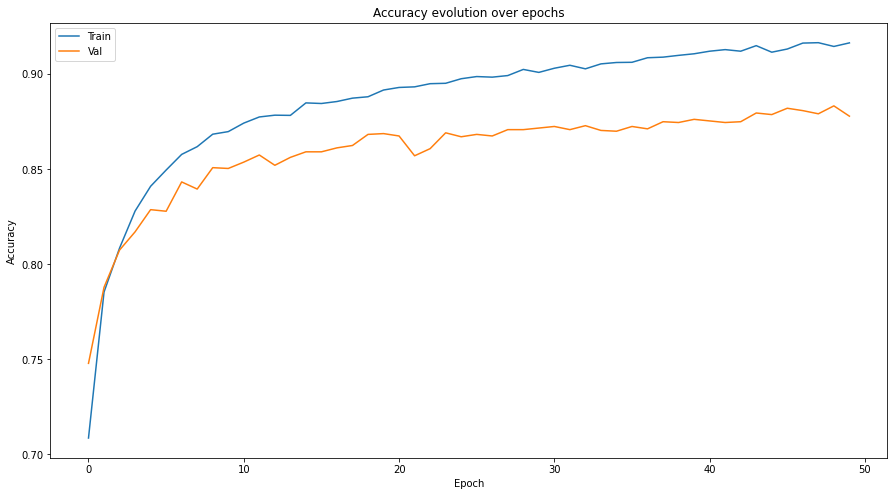

In [35]:
# Plot training history
fig, ax = plot_history(history)
_ = ax.set_title("Accuracy evolution over epochs")

In [88]:
# Evaluate the keras model
train_preds = model.predict(Xtr)
test_preds = model.predict(Xts)
train_err = calc_err(train_preds, Ytr)
test_err = calc_err(test_preds, Yts)
print("Training error: %.2f%%, Test error: %.2f%%" % (train_err * 100, test_err * 100))

63/63 [==============================] - 0s 1ms/step
Training error: 8.53%, Test error: 12.35%


In [89]:
_, accuracy = model.evaluate(Xts, Yts)
print('Test accuracy: %.2f%%' % (accuracy*100))

63/63 [==============================] - 0s 2ms/step - loss: 0.3082 - accuracy: 0.8765
Test accuracy: 87.65%


It makes sense the the test accuracy of the CNN is higher than the one of the dense network because it's able to extract features from the images and use them to classify them. The dense network instead is not able to extract features from the images. On the other hand though, the CNN seems to overfit a little, this is probably due to the fact that the number of parameters is too high and hence it's not able to generalize well. Finally, the CNN takes more time to train than the dense network.